Notebook inspired from [This YouTube Tutorial](https://www.youtube.com/watch?v=68HR_eyzk00&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE&index=2&t=51s&ab_channel=DigitalSreeni)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob

from tqdm import tqdm
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

In [4]:
size_x=128
size_y=128

In [22]:
################# Storing Train Images into an array #############
train_images=[]

for directory_path in glob.glob("/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images"):
    for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        #print(img_path)
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=cv2.resize(img,(size_y, size_x))
        train_images.append(img)
        
train_images = np.array(train_images) #converting list to array

In [23]:
################# Storing Train Masks into an array #############
train_masks = []

for directory_path in glob.glob("/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks"):
    for mask_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        mask=cv2.imread(mask_path,0)
        mask=cv2.resize(mask,(size_y,size_x))
        train_masks.append(mask)
        
train_masks = np.array(train_masks) #converting list to array

In [24]:
len(train_images), len(train_masks)

(2841, 2841)

In [25]:
train_images[0].shape, train_masks[0].shape

((128, 128, 3), (128, 128))

In [26]:
np.min(train_images[0]), np.max(train_images[0]), np.min(train_masks[0]), np.max(train_masks[0])

(0, 177, 0, 255)

In [27]:
#normalizing
x = train_images/255
y = train_masks/255

In [28]:
np.min(x[0]), np.max(x[0]), np.min(y[0]), np.max(y[0])

(0.0, 0.6941176470588235, 0.0, 1.0)

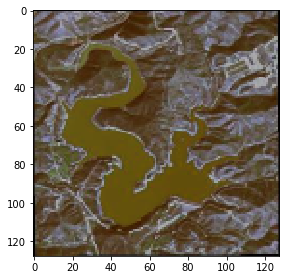

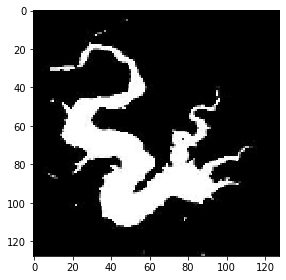

0.0 0.7372549019607844
(128, 128, 3)
0.0 1.0
(128, 128)


In [43]:
########## Displaying random image from X_train and Y_train ######### 
random_num = random.randint(0,516)
imshow(x[random_num])
plt.show()
imshow(y[random_num])
plt.show() 

test_img = x[random_num]
test_img2 = y[random_num]
print(test_img.min(), test_img.max())
print(test_img.shape)

print(test_img2.min(), test_img2.max())
print(test_img2.shape)

In [44]:
#splitting 
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [45]:
#UNet model building
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()
    
    return model

In [46]:
def get_model():
    return simple_unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [47]:
model = get_model()
model.summary()

2023-01-06 10:41:25.707766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 10:41:25.709180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 10:41:25.934093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 10:41:25.937060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 10:41:25.939272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
history=model.fit(x_train,
          y_train,
          batch_size=25, 
          epochs=60,
          verbose=1,
          validation_data=(x_val, y_val))

2023-01-06 10:42:27.069534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2023-01-06 10:42:29.985232: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


91/91 [==============================] - 20s 89ms/step - loss: 0.5639 - accuracy: 0.6031 - val_loss: 0.5174 - val_accuracy: 0.6419
Epoch 2/60
91/91 [==============================] - 6s 61ms/step - loss: 0.5046 - accuracy: 0.6457 - val_loss: 0.4819 - val_accuracy: 0.6477
Epoch 3/60
91/91 [==============================] - 6s 62ms/step - loss: 0.4729 - accuracy: 0.6645 - val_loss: 0.4378 - val_accuracy: 0.6813
Epoch 4/60
91/91 [==============================] - 6s 61ms/step - loss: 0.4375 - accuracy: 0.6831 - val_loss: 0.4240 - val_accuracy: 0.6882
Epoch 5/60
91/91 [==============================] - 6s 63ms/step - loss: 0.4010 - accuracy: 0.7044 - val_loss: 0.4198 - val_accuracy: 0.6887
Epoch 6/60
91/91 [==============================] - 6s 62ms/step - loss: 0.3814 - accuracy: 0.7108 - val_loss: 0.4330 - val_accuracy: 0.6849
Epoch 7/60
91/91 [==============================] - 6s 62ms/step - loss: 0.3890 - accuracy: 0.7083 - val_loss: 0.3785 - val_accuracy: 0.7116
Epoch 8/60
91/91 [=====

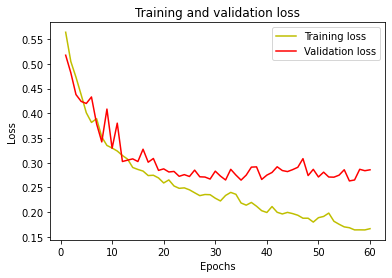

In [50]:
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

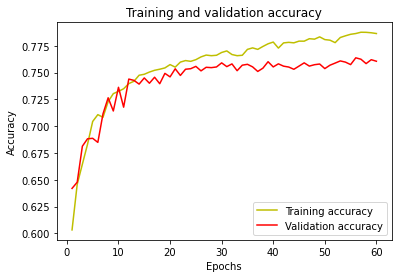

In [51]:
#plot the training and validation accuracy at each epoch
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()